In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [37]:
df = pd.read_excel('RJ_Reconstrucao_Moluscos_2024_06_06.xlsx')

In [38]:
df.head()

,Ano,Lula_art,Lula_ind,Lula_art_ind,Lula_oceanica_art,Calamar_ind,Polvo_art,Polvo_ind,Polvo_art_ind,Polvo_cabecinha_art,...,Mexilhao_art,Mexilhao_ind,Mexilhao_mangue_art,Caramujo_art,Caramujo_ind,Vieira_ind,Berbigao_art,Vongole_art,TOTAL_MOLLUSCS,TOTAL_GROUPS_F&M
0,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28137.0
1,1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27432.0
2,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26648.0
3,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24552.0
4,1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22755.0


In [39]:
print(df['Mexilhao_ind'])

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
68   NaN
69   NaN
70   NaN
71   NaN
72   NaN
Name: Mexilhao_ind, Length: 73, dtype: float64


In [40]:
x0 = df[['Ano', 'Mexilhao_art']].dropna().values
x1 = df[['Ano', 'Mexilhao_ind']].dropna().values

In [41]:
df_x0= pd.DataFrame(x0, columns= ['Ano', 'Mexilhao_art'])
df_x1=pd.DataFrame(x1, columns= ['Ano', 'Mexilhao_ind'])
df_x0= df_x0.drop_duplicates(subset= 'Mexilhao_art')
df_x1= df_x1.drop_duplicates(subset='Mexilhao_ind')

In [42]:
print(len(df_x1))

3


Normalização Dos dados

In [43]:
x = np.array(df_x0['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(df_x0['Mexilhao_art'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

In [44]:
def leaky_relu(x):
    return tf.nn.RMSprop(x, alpha=0.01)

In [34]:
class PrintEveryNEpochs(tf.keras.callbacks.Callback):
    def __init__(self, N):
        super(PrintEveryNEpochs, self).__init__()
        self.N = N

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.N == 0:
            print(f"Epoch {epoch + 1}: loss = {logs['loss']}")

Epoch 100: loss = 0.3520600497722626
Epoch 200: loss = 0.36251381039619446
Epoch 300: loss = 0.33956271409988403
Epoch 400: loss = 0.3328593969345093
Epoch 500: loss = 0.33279770612716675
Epoch 600: loss = 0.336719274520874
Epoch 700: loss = 0.30304834246635437
Epoch 800: loss = 0.30957961082458496
Epoch 900: loss = 0.29995113611221313
Epoch 1000: loss = 0.2490757554769516
Epoch 1100: loss = 0.27092137932777405
Epoch 1200: loss = 0.24686679244041443
Epoch 1300: loss = 0.25566065311431885
Epoch 1400: loss = 0.2512800097465515
Epoch 1500: loss = 0.2476031333208084
Epoch 1600: loss = 0.24585974216461182
Epoch 1700: loss = 0.2618694007396698
Epoch 1800: loss = 0.24940118193626404
Epoch 1900: loss = 0.24196581542491913
Epoch 2000: loss = 0.25380852818489075
Epoch 2100: loss = 0.24534453451633453
Epoch 2200: loss = 0.26950907707214355
Epoch 2300: loss = 0.2456003576517105
Epoch 2400: loss = 0.24245426058769226
Epoch 2500: loss = 0.25839030742645264
Epoch 2600: loss = 0.24610422551631927
Epoc

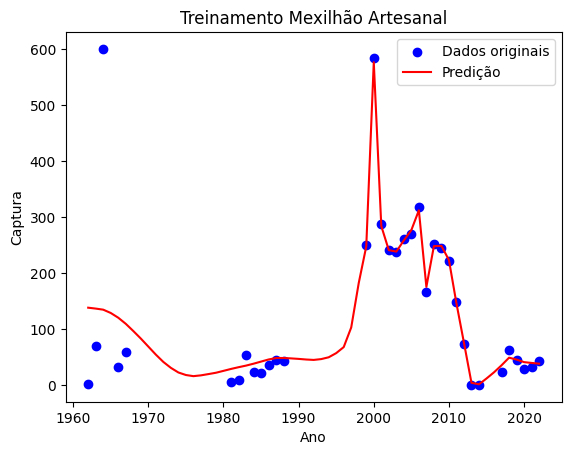

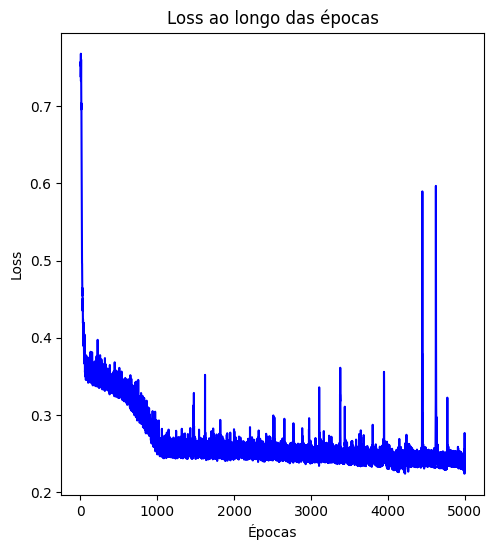

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])

print_every_100_epochs = PrintEveryNEpochs(N=100) 

history = model.fit(
    x_normalized, y_normalized, 
    epochs=5000, 
    batch_size=12, 
    steps_per_epoch=50, 
    verbose=0,  
    callbacks=[print_every_100_epochs]
)

x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Treinamento Mexilhão Artesanal')
plt.legend()
plt.show()

loss_values = history.history['loss']
#accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predição para o ano 1965: 128.5850830078125
Predição para o ano 1968: 96.38920593261719
Predição para o ano 1969: 82.93623352050781
Predição para o ano 1970: 68.59239959716797
Predição para o ano 1971: 54.254478454589844
Predição para o ano 1972: 41.15204620361328
Predição para o ano 1973: 30.61663818359375
Predição para o ano 1974: 22.35352325439453
Predição para o ano 1975: 17.82501983642578
Predição para o ano 1976: 15.797065734863281
Predição para o ano 1977: 17.211090087890625
Predição para o ano 1978: 19.483291625976562
Predição para o ano 1979: 21.8773193359375
Predição para o ano 1980: 25.23413848876953
Predição para o ano 1990: 46.60102081298828
Predição para o ano 1991: 45.513214111328125
Predição para o ano 1992: 44.77307891845703
Predição para o ano 1993: 46.23358917236328
Predição para o ano 1994: 49.487815856933594
Predição para o ano 1995: 56.903564453125
Predição para o ano 1996: 67.67926025390625
Predição para o ano 1997: 102.75425

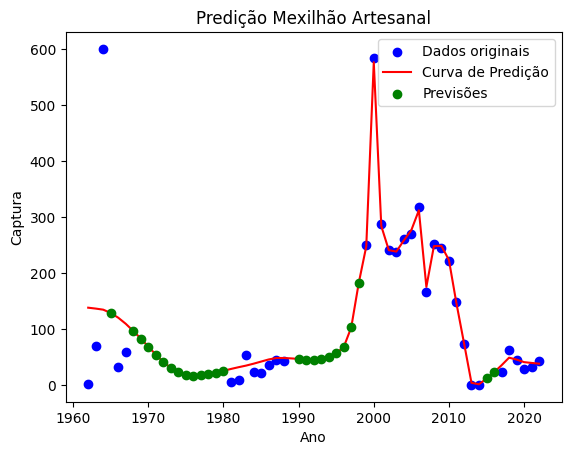

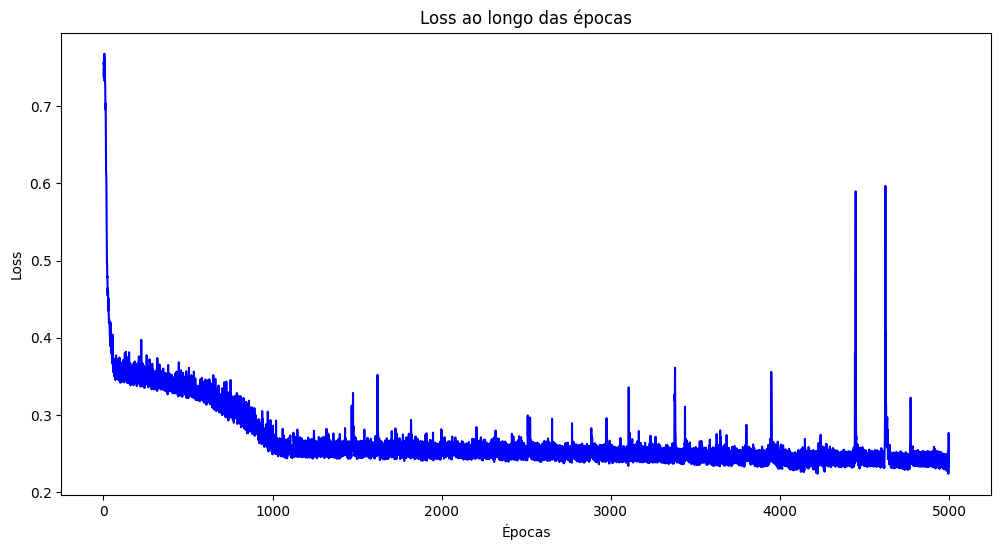

In [18]:

anos_para_prever = np.array([1965, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 2015, 2016]).reshape(-1, 1)

anos_para_prever_normalizados = (anos_para_prever - x_mean) / x_std

predicoes_normalizadas = model.predict(anos_para_prever_normalizados)

predicoes = predicoes_normalizadas * y_std + y_mean


for ano, predicao in zip(anos_para_prever.flatten(), predicoes.flatten()):
    print(f"Predição para o ano {ano}: {predicao}")


df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')
df_anos_para_prever = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.concat([df_combined, df_anos_para_prever]).drop_duplicates().sort_values(by='Ano')


plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Curva de Predição')
plt.scatter(df_anos_para_prever['Ano'], df_anos_para_prever['Captura Preditos'], color='green', label='Previsões', zorder=5)
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Predição Mexilhão Artesanal')
plt.legend()
plt.show()


loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()


In [19]:
df_originais = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_preditos = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.merge(df_originais, df_preditos, on='Ano', how='outer').sort_values(by='Ano')
print(df_combined)
df_combined.to_excel('Mexilhão_artesanal_reconstruido.xlsx', index=False)

       Ano  Captura Original  Captura Preditos
0   1962.0          2.000000               NaN
1   1963.0         70.000000               NaN
2   1964.0        600.000000               NaN
3   1965.0               NaN        128.585083
4   1966.0         32.000000               NaN
5   1967.0         59.000000               NaN
6   1968.0               NaN         96.389206
7   1969.0               NaN         82.936234
8   1970.0               NaN         68.592400
9   1971.0               NaN         54.254478
10  1972.0               NaN         41.152046
11  1973.0               NaN         30.616638
12  1974.0               NaN         22.353523
13  1975.0               NaN         17.825020
14  1976.0               NaN         15.797066
15  1977.0               NaN         17.211090
16  1978.0               NaN         19.483292
17  1979.0               NaN         21.877319
18  1980.0               NaN         25.234138
19  1981.0          5.000000               NaN
20  1982.0   

MEXILHÃO INDUSTRIAL

In [46]:
x = np.array(df_x1['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(df_x1['Mexilhao_ind'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

Epoch 100: loss = 0.0028505169320851564
Epoch 200: loss = 7.255393370542151e-07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


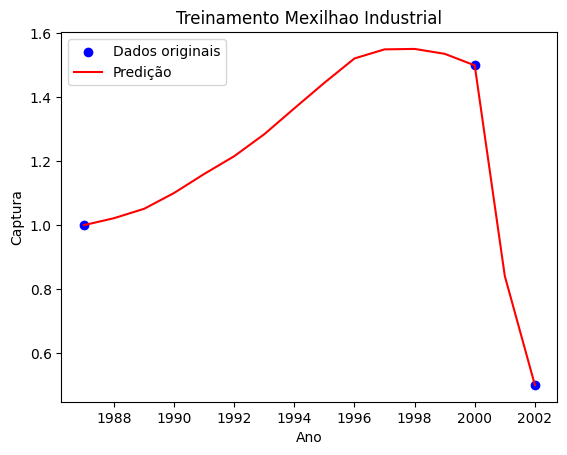

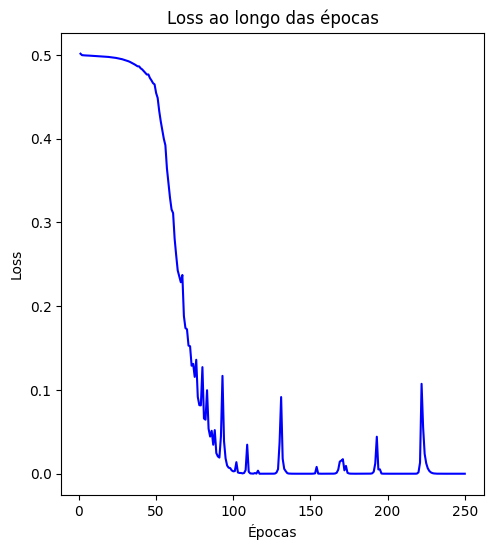

In [47]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])

print_every_100_epochs = PrintEveryNEpochs(N=100) 

history = model.fit(
    x_normalized, y_normalized, 
    epochs=250, 
    batch_size=12, 
    steps_per_epoch=50, 
    verbose=0,  
    callbacks=[print_every_100_epochs]
)
x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Treinamento Mexilhao Industrial')
plt.legend()
plt.show()

loss_values = history.history['loss']
#accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predição para o ano 1990: 1.1007506847381592
Predição para o ano 1991: 1.1602118015289307
Predição para o ano 1992: 1.2158902883529663
Predição para o ano 1993: 1.2846205234527588
Predição para o ano 1994: 1.3656723499298096
Predição para o ano 2016: -2.9921135902404785


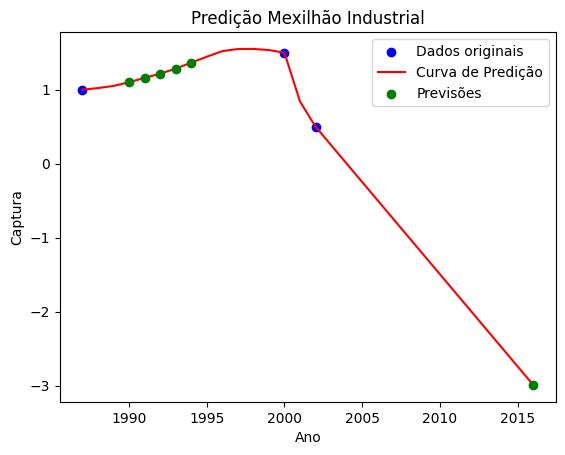

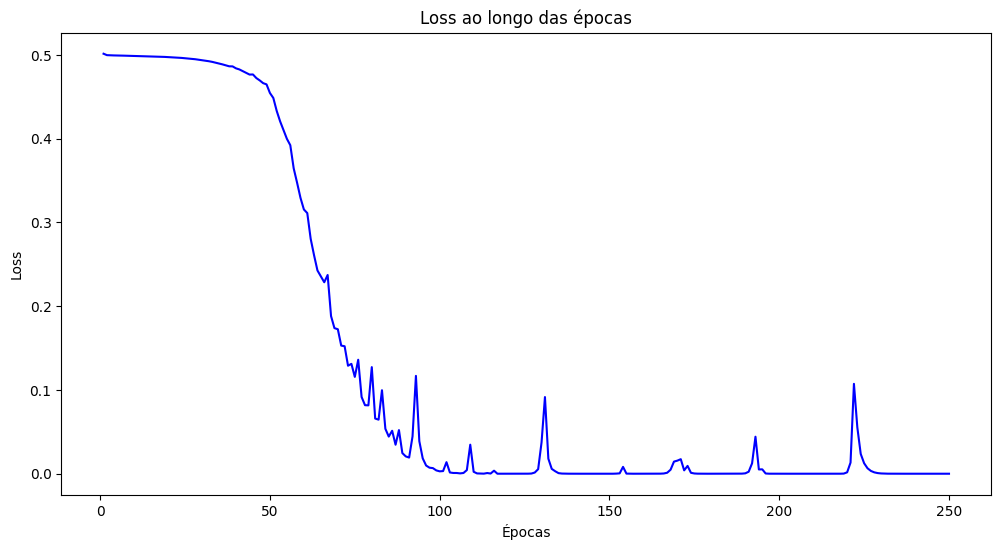

In [48]:
anos_para_prever = np.array([1990, 1991, 1992, 1993, 1994, 2016]).reshape(-1, 1)
anos_para_prever_normalizados = (anos_para_prever - x_mean) / x_std
predicoes_normalizadas = model.predict(anos_para_prever_normalizados)
predicoes = predicoes_normalizadas * y_std + y_mean

for ano, predicao in zip(anos_para_prever.flatten(), predicoes.flatten()):
    print(f"Predição para o ano {ano}: {predicao}")


df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')
df_anos_para_prever = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.concat([df_combined, df_anos_para_prever]).drop_duplicates().sort_values(by='Ano')


plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Curva de Predição')
plt.scatter(df_anos_para_prever['Ano'], df_anos_para_prever['Captura Preditos'], color='green', label='Previsões', zorder=5)
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Predição Mexilhão Industrial')
plt.legend()
plt.show()


loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()